# Chap16 - 강화학습 (Reinforcement Learning)

이번 포스팅에서는 게임 뿐만아니라 보행 로봇, 자율주행 자동차 등 다양한 분야에서 사용되는 **강화학습**(RL, Reinforcement Learning)에 대해 알아보도록 하자.

## 1. 보상을 최적화하기 위한 학습

강화학습에서 소프트웨어 **에이전트**(agent)는 **관측**(observation)을 하고 주어진 **환경**(environment)에서 **행동**(action)한다. 그리고 그 결과로 **보상**(reward)을 받는다(그림 출처: [wikipedia](https://en.wikipedia.org/wiki/Reinforcement_learning)).



![](./images/rl.png)



에이전트의 목적은 보상의 장기간(long-term) 기대치를 최대로 만드는 행동을 학습하는 것이다. 즉, 에이전트는 환경안에서 행동하고 시행착오를 통해 보상이 최대가 되도록 학습한다. 

이러한 강화학습의 정의는 다음과 같이 다양한 문제에 적용할 수 있다는 것을 보여준다.

- **a** : 보행 로봇(walking robot)에서는 에이전트(agent)는 보행 로봇을 제어하는 프로그램일 수 있다. 이 때 환경(environment)은 실제 세상이고, 에이전트는 카메라나 센서등을 통해 환경을 관찰(observation)한다. 그런 다음 걷는 행동(action)을 한다. 엥전트는 목적지에 도착할 때 양수(positive)보상을 받고, 잘못된 곳으로 가거나 넘어질 때 음수(negative) 보상(패널티)을 받는다.
- **b** : 팩맨(pac-man)이라는 게임에서는 에이전트는 팩맨을 제어하는 프로그램이다. 환경은 게임상의 공간이고, 행동은 조이스틱의 방향이 된다. 관측은 스크린샷이 되고 보상은 게임의 점수이다.
- **c** : 에이전트는 주식시장의 가격을 관찰하고 행동은 얼마나 사고팔아야 할지 결정하는 것이며, 보상은 수익과 손실이 된다.



![](./images/rl02.PNG)

## 2. 정책 탐색 (Policy Search)

에이전트(agent)가 행동(action)을 결정하기 위해 사용하는 알고리즘을 **정책(policy)**이라고 한다. 예를 들어 관측(observation)을 입력으로 받고 행동(action)을 출력하는 신경망이 정책이 될 수 있다.



![](./images/rl03.PNG)



정책은 정해져 있는 알고리즘이 아니기 때문에, 어떠한 알고리즘도 될 수 있다. 예를들어 30분 동안 수집한 먼지의 양을 보상으로 받는 로봇 청소기가 있다고 하자. 이 청소기의 정책은 매 초마다 어떤 확률 $p$ 만큼 전진할 수도 있고, 또는 ($1-p$)의 확률로 랜덤하게 $-r$과 $+r$ 사이에서 회전하는 것일 수도 있다. 이 정책에는 무작위성이 포함되어 있으므로 **확률적 정책**(stochastic policy)라고 한다.

이러한 정책을 가지고 '30분 동안 얼마나 많은 먼지를 수집할 것인가'에 대한 문제를 해결하기 위해 어떻게 로봇 청소기를 훈련(training) 시킬 수 있을까? 로봇 청소기 예제에는 변경이 가능한 두 개의 **정책 파라미터**(policy parameter)가 있는데, 확률 $p$와 각도의 범위  $r$이다. $p$와 $r$은 다양한 조합이 될 수 있는데 이처럼 정책 파라미터의 범위를 **정책 공간**(policy space)라고 하며, 정책 공간에서 가장 성능이 좋은 파라미터를 찾는 것을 **정책 탐색**(policy search)라고 한다. 

정책 탐색에는 다음과 같은 방법들이 있다.

- **단순한(naive) 방법** : 다양한 파라미터 값들로 실험한 뒤 가장 성능이 좋은 파라미터를 선택한다.
- **유전 알고리즘(genetic algorithm)** :  기존의 정책(부모)에서 더 좋은 정책(자식)을 만들어 내는 과정(진화)를 통해서 좋은 정책을 찾을 때까지 반복하는 방법이다.
- **정책 그래디언트(PG, policy gradient)** : 정책 파라미터에 대한 보상(reward)의 그래디언트(gradient)를 평가해서 높은 보상의 방향을 따르는 그래디언트로(**gradient ascent**) 파라미터를 업데이트하는 최적화 방법이다.

### Set Up

In [1]:
import os, sys
import numpy as np
import tensorflow as tf

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


# 맷플롯립 설정
from IPython.display import HTML
%matplotlib inline
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
# matplotlib.rc('font', family='AppleGothic')  # MacOS
matplotlib.rc('font', family='Malgun Gothic')  # Windows
# matplotlib.rc('font', family='NanumBarunGothic') # Linux
plt.rcParams['axes.unicode_minus'] = False

## 3. OpenAI Gym

강화학습에서 중요한 요소 중 하나는 에이전트(agent)를 훈련시키기 위한 **시뮬레이션 환경**이 필요하다.

**[OpenAI Gym](http://gym.openai.com)**은 다양한 종류의 시뮬레이션 환경(아타리 게임, 보드 게임, 물리 시뮬레이션 등)을 제공하는 툴킷이며, 이를 이용하여 에이전트를 훈련시키고 RL 알고리즘을 개발할 수 있다.

OpenAI Gym의 설치는 다음과 같이 `pip`명령을 통해 설치할 수 있다.

```bash
pip install --upgrade gym
```

Jupyter Notebook에서 랜더링(rendering)문제를 해결하기 위해서는 아래와 같은 함수가 필요하다. → [[링크]](https://github.com/rickiepark/handson-ml/blob/master/16_reinforcement_learning.ipynb) 참고

In [2]:
from render_notebook import render_cart_pole

def plot_cart_pole(env, obs):
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    
def update_scene(num, frames, patch):
    plt.close()  # 이전 그래프를 닫지 않으면 두 개의 그래프가 출력되는 matplotlib의 버그로 보입니다.
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, figsize=(5,6), repeat=False, interval=40):
    fig = plt.figure(figsize=figsize)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), 
                                   frames=len(frames), repeat=repeat, interval=interval)

obs.shape : (4,)
obs : [-0.0021915   0.0120873   0.02120733  0.02568694]
img.shape : (400, 600, 3)


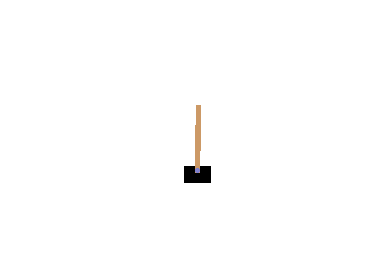

In [3]:
import gym

env = gym.make("CartPole-v0")
obs = env.reset()
img = render_cart_pole(env, obs)

print('obs.shape :', obs.shape)
print('obs :', obs)
print('img.shape :', img.shape)
plot_cart_pole(env, obs)

위의 코드에서 각 메서드에 대해 알아보도록 하자.

- `make()` 함수는 환경(`env`)을 만든다. 
- 환경을 만든 후 `reset()` 메서드를 사용해 초기화 해줘야 하는데, 이 함수는 첫 번째 관측(`obs`)를 리턴한다. 위의 출력결과에서도 확인할 수 있듯이 CartPole 환경에서의 관측은 길이가 `4`인 `NumPy`배열이다.
  - `obs = [카트의 수평 위치, 속도, 막대의 각도, 각속도]`

- `render()` 메서드는 jupyter notebook이나 별도의 창에 위의 그림과 같이 환경을 출력 해준다.

CartPole의 환경에서는 어떤 행동(action)이 가능한지 `action_space`를 통해 확인할 수 있다.

In [4]:
print('env.action_space :', env.action_space)

env.action_space : Discrete(2)


`Discrete(2)`는 가능한 행동이 `0`(왼쪽)과 `1`(오른쪽)이라는 것을 의미한다. 아래의 코드에서 `step()` 메서드를  통해 막대를 오른쪽(`1`)으로 가속 시켜보자.

In [5]:
action = 1  # 오른쪽으로 가속
obs, reward, done, info = env.step(action)

print('obs :', obs)
print('reward :', reward)
print('done :', done)
print('info :', info)

obs : [-0.02484453  0.16747024  0.03900602 -0.27989894]
reward : 1.0
done : False
info : {}


위의 출력결과 처럼, `step()` 메서드는 주어진 행동을 실행하고 `obs, reward, done, info` 4개의 값을 리턴한다.

- `obs` : 새로운 관측값
- `reward` : 행동에 대한 보상을 말하며, 여기서는 매 스텝마다 `1`의 보상을 받는다.
- `done` : 값이 `True` 이면, 에피소드(게임 한판)가 끝난것을 말한다. 여기서는 막대가 넘어진 경우를 말한다.
- `info` : 추가적인 디버깅 정보가 딕셔너리 형태로 저장된다. 여기서는 별도의 정보가 따로 없다.

이번에는 간단한 정책(policy)를 하드코딩 해보도록 하자. 이 정책은 막대가 기울어지는 방향과 반대로 가속시키며, 아래의 코드처럼 20번의 에피소드를 실행해서 얻은 평균 보상을 확인하는 코드이다.

In [6]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle <0 else 1

frames, totals = [], []
for episode in range(20):
    episode_rewards = 0
    obs = env.reset()
    for step in range(1000):  # 최대 스텝을 1000번으로 설정
        img = render_cart_pole(env, obs)
        frames.append(img)
        
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [7]:
# ! conda install -c conda-forge ffmpeg
video = plot_animation(frames, figsize=(6,4))
HTML(video.to_html5_video())  # HTML5 동영상으로 만들어 줍니다

위의 정책에 대한 결과를 아래의 코드를 통해 확인할 수 있다.

In [8]:
import numpy as np

print('totals mean :', np.mean(totals))
print('totals std :', np.std(totals))
print('totals min :', np.min(totals))
print('totals max :', np.max(totals))

totals mean : 43.75
totals std : 8.166241485530538
totals min : 25.0
totals max : 56.0


20번 정도의 에피소드를 진행했을 때 이 정책(`basic_policy()`)는 막대를 쓰러뜨리지 않고 최대 52번 스텝까지만 진행한 것을 확인할 수 있다. 

## 4. 신경망 정책

이번에는 위의 CartPole 예제에서 정책(policy)을 **신경망(neural networks)**을 적용해 보도록하자.  이 신경망은 관측(`obs`)을 입력으로 받고 실행할 행동(`action`)에 대한 **확률**을 출력한다. 그런다음 출력된 확률에 따라 **랜덤하게** 행동을 선택하여 수행한다. 



![](./images/rl-nn.PNG)



이처럼 가장 높은 점수의 행동을 바로 선택하지 않고 신경망이 출력한 확률을 랜덤하게 행동을 선택하는 이유는, 에이전트(agent)가 새로운 행동을 **탐험(exploring)** 하는 것과 잘 할 수 있는 행동을 **활용(exploiting)**하는 것 사이에 균형이 잘 맞게끔 하기 위해서다. 이를 교재에서는 다음과 같은 비유를 들어 설명하고 있다.

> *어떤 음식점에 처음 방문했다고 하자. 모든 메뉴가 좋아 보여서 아무거나 골랐는데, 이 음식이 맛있었다면 다음에 다시 이 메뉴를 주문할 가능성이 높을 것이다. 하지만, 이 확률이 100%가 되어서는 안되는데 그 이유는 다른 더 맛있는 메뉴를 전혀 시도해보지 않을 것이기 때문에, 이를 방지하기 위해 확률을 100%라고 설정하지 않는다.*



다음의 예제 코드는 텐서플로(TensorFlow)를 이용하여 CartPole 환경에 대해 신경망 정책을 구현한 코드이다.


In [9]:
import tensorflow as tf

In [16]:
# 1. layers params
n_inputs = 4  # == env.observation_space.shape[0]
n_hidden = 16  # CartPole은 간단한 환경이므로 16개의 뉴런을 사용
n_outputs = 1  # 왼쪽(0)으로 이동할 확률을 출력
initializer = tf.keras.initializers.he_normal()

# 2. Network
inputs = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(inputs, n_hidden, activation=tf.nn.elu, 
                         kernel_initializer=initializer)
outputs = tf.layers.dense(hidden, n_outputs, activation=tf.nn.sigmoid, 
                          kernel_initializer=initializer)

# 3. 출력된 확률을 기반으로 랜덤하게 행동을 선택
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
# tf.multinomial() : outputs의 확률로 0, (1-outputs)의 확률로 1을 출력 
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

# 4. Training
n_max_steps = 1000
frames, totals = [], []

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for episode in range(50):
        if episode % 5 == 0:
            print('episode : {}'.format(episode))
        episode_rewards = 0
        obs = env.reset()
        for step in range(n_max_steps):
            img = render_cart_pole(env, obs)
            frames.append(img)
            action_val = action.eval(feed_dict={inputs: obs.reshape(1, n_inputs)})
            obs, reward, done, info = env.step(action_val[0][0])
            episode_rewards += reward
            if done:
                break
        totals.append(episode_rewards)
env.close()

episode : 0
episode : 5
episode : 10
episode : 15
episode : 20
episode : 25
episode : 30
episode : 35
episode : 40
episode : 45


In [17]:
video = plot_animation(frames, figsize=(6,4))
HTML(video.to_html5_video())  # HTML5 동영상으로 만들어 줍니다

In [18]:
import numpy as np

print('totals mean :', np.mean(totals))
print('totals std :', np.std(totals))
print('totals min :', np.min(totals))
print('totals max :', np.max(totals))

totals mean : 25.18
totals std : 14.603684466599516
totals min : 10.0
totals max : 77.0


위의 코드에서 볼 수 있듯이, 관측(`obs`)을 입력받아 행동(`action`)을 출력하는 신경망 정책을 텐서플로를 이용해 구현해 보았다. 하지만, 위의 코드에서는 훈련을 시키는 코드는 포함되어있지 않다. 그렇다면, 이 신경망 정책을 어떻게 훈련 시킬 수 있는지에 대해 알아보도록 하자.

### Cross-Entropy 손실함수를 이용해 훈련 시키기

In [24]:
# 1. layers params
n_inputs = 4  # == env.observation_space.shape[0]
n_hidden = 16  # CartPole은 간단한 환경이므로 16개의 뉴런을 사용
n_outputs = 1  # 왼쪽(0)으로 이동할 확률을 출력
initializer = tf.keras.initializers.he_normal()

# 2. Network
inputs = tf.placeholder(tf.float32, shape=[None, n_inputs])
labels = tf.placeholder(tf.float32, shape=[None, n_outputs])
hidden = tf.layers.dense(inputs, n_hidden, activation=tf.nn.elu, 
                         kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs, activation=None,
                         kernel_initializer=initializer)
outputs = tf.nn.sigmoid(logits)  # 왼쪽 (0)에 대한 확률

# 3. 출력된 확률을 기반으로 랜덤하게 행동을 선택
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
# tf.multinomial() : outputs의 확률로 0, (1-outputs)의 확률로 1을 출력 
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

# 4. loss & optimizer 추가
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits)
train_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cross_entropy)

# 4. Training
n_max_steps = 1000

frames, totals = [], []

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for episode in range(50):
        if episode % 5 == 0:
            print('episode : {}'.format(episode))
        episode_rewards = 0
        obs = env.reset()
        for step in range(n_max_steps):
            img = render_cart_pole(env, obs)
            frames.append(img)
            
            # angle < 0 이면 proba(left)=1. 이 되어야 하고 아닐 경우 0.이 되어야 함
            target_probas = np.array([[1.] if obs[2] < 0 else [0.]])
            action_val, _ = sess.run([action, train_op], feed_dict={inputs: obs.reshape(1, n_inputs), 
                                                                    labels: target_probas})
            obs, reward, done, info = env.step(action_val[0][0])
            episode_rewards += reward
            if done:
                break
        totals.append(episode_rewards)
env.close()

episode : 0
episode : 5
episode : 10
episode : 15
episode : 20
episode : 25
episode : 30
episode : 35
episode : 40
episode : 45


In [26]:
video = plot_animation(frames, figsize=(6,4))
HTML(video.to_html5_video())  # HTML5 동영상으로 만들어 줍니다

In [25]:
print('totals mean :', np.mean(totals))
print('totals std :', np.std(totals))
print('totals min :', np.min(totals))
print('totals max :', np.max(totals))

totals mean : 46.84
totals std : 27.58503942357161
totals min : 13.0
totals max : 189.0


## 5. 행동평가: 신용 할당 문제

만약, 각 스텝마다 가장 좋은 행동이 무엇인지 알고 있다면, 신경망이 예측(출력)한 확률과 타깃 확률 사이의 교차 엔트로피(cross entropy)를 최소화 하도록 신경망을 훈련시킬 수 있다.  `CartPole` 환경에서는 행동이 왼쪽(`0`)/오른쪽(`1`)  두 가지 경우 밖에 없기 때문에 교차 엔트로피를 이용해 구현할 수 있지만([ExcelsiorCJH's github](https://github.com/ExcelsiorCJH/Hands-On-ML/blob/master/Chap16-Reinforcement_Learning/Chap16-Reinforcement_Learning.ipynb) 참고), 대부분의 강화학습에서는 에이전트가 얻을 수 있는 것은 행동에 대한 보상(`reward`)뿐이다.

일반적으로 보상은 스파스(sparse)하고 지연(delayed)되어 나타나는데, 예를 들어 `CartPole`에서 에이전트가 100스텝 동안 막대의 균형을 유지했을 경우, 100번의 행동(action) 중에 어떤 것이 좋고/나쁜지를 알지 못한다. 다만 알 수 있는 것은 막대가 마지막 행동 뒤에 쓰러졌다는 것만 알 수 있다. 하지만 마지막 행동 때문에 막대가 쓰러졌다고는 볼 수 없는데, 이러한 것을 **신용 할당 문제(credit assignment problem)**라고 한다. 즉, 에이전트가 보상을 받았을 때 어떤 행동 때문에 받았는지 알기 어렵다.

이러한 문제를 해결하기 위해 주로 사용하는 전략은 행동이 일어난 후 각 단계마다 **할인 계수(discount factor)** $\gamma$를 적용한 보상을 모두 합하여 행동을 평가하는 것이다.  

할인 계수의 역할은 다음과 같다.

- 할인 계수 $\gamma$가 `0`에 가까우면 미래의 보상은 현재의 보상보다는 중요하게 취급 되지 않는다.
- `1`에 가까우면 미래의 보상이 현재의 보상만큼 중요하게 고려된다. 
- 일반적으로 할인 계수는 `0.95 ~ 0.99` 이다.
  - $\gamma = 0.95$ 이면, 13 스텝만큼의 미래서 받는 보상은 당장 받는 보상에 비해 약 절반 정도의 가치가 된다($0.95^{13} \approx 0.5$).



아래의 그림에서 처럼 에이전트가 오른쪽으로 3번 이동하기로 결정했을 경우, 첫 번째 스텝에서 `+10`, 두 번째 스텝에서 `0`, 세 번째 스텝에서 `-50`의 보상을 받는다고 할 때, 할인 계수 $\gamma = 0.8$을 적용하게 되면, 첫 번째 행동의 전체 보상은 $10 + \gamma \times 0 + \gamma^{2} \times (-50) = -22$가 된다. 

![](./images/discount.PNG)

이렇게 할인 계수 $\gamma$를 적용한 보상의 합을 수식으로 나타내면 다음과 같다. ($n$ = 전체 스텝, $t$ = 스텝)

$$
\begin{align*}
R_{t} &= r_{t} + \gamma r_{t+1} + \gamma^{2} r_{t+2} + \cdots + \gamma^{n-t} r_{n} \\ &= r_{t} + \gamma \left( r_{t+1} + \gamma \left( r_{t+2} + \cdots \right) \right) \\ &= r_{t} + \gamma R_{t+1}
\end{align*}
$$

## 6. 정책 그래디언트 (PG, Policy Gradient)

'2 - 정책 탐색' 에서 간단하게 살펴 보았듯이 정책 그래디언트(PG)는 높은 보상을 얻는 방향의 그래디언트로 정책(policy)의 파라미터를 최적화하는 알고리즘이다. PG 알고리즘 중 인기있는 알고리즘은 1992년 [Ronald Williams](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)가 제안한 **REINFORCE** 알고리즘이다.  

**REINFORCE**의 방법은 다음과 같다.

1. 먼저 신경망 정책이 여러 번에 걸쳐 게임을 플레이하고 매 스텝마다 선택된 행동이 더 높은 가능성을 가지도록 만드는 그래디언트를 계산한다. 
2. 몇 번의 에피소드를 실행한 다음, 각 행동의 점수를 계산한다. 
3. 한 행동 점수가 양수이면 선택될 가능성이 높도록 `1`번에서 계산한 그래디언트를 적용한다. 만약, 음수일 경우 덜 선택 되도록 반대의 그래디언트를 적용한다. 
   - 그래디언트 벡터와 행동 점수를 곱해주면 된다.
4. 마지막으로 모든 결과 그래디언트 벡터의 평균을 구한 다음 경사 하강법을 수행한다.



아래의 코드는 텐서플로를 이용해 REINFORCE 알고리즘을 구현한 코드이다. 

### Discount Reward 함수 구현

In [17]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

In [18]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22., -40., -50.])

In [19]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

### Policy Gradient를 적용한 신경망 구현

In [16]:
import tensorflow as tf

reset_graph()

n_inputs = 4
n_hidden = 16
n_outputs = 1
initializer = tf.keras.initializers.he_normal()

# Network
inputs = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden = tf.layers.dense(inputs, n_hidden, activation=tf.nn.elu,
                         kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs, activation=None,
                         kernel_initializer=initializer)
outputs = tf.nn.sigmoid(logits)  # 행동 0(왼쪽)에 대한 확률
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

# target & loss & optimizer
labels = 1. - tf.to_float(action)  # 타겟 확률
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits)
optimizer = tf.train.AdamOptimizer(0.01)
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, var in grads_and_vars]

gradient_placeholders, grads_and_vars_feed = [], []
for grad, var in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, var))

train_op = optimizer.apply_gradients(grads_and_vars_feed)

saver = tf.train.Saver()

In [20]:
env = gym.make('CartPole-v0')

n_iterations = 100  # 훈련 반복 횟수
n_max_steps = 1000  # 에피소드별 최대 스텝
n_games_per_update = 10  # 10번의 에피소드마다 정책을 훈련
save_iterations = 10  # 10번의 훈련 반복마다 모델을 저장
discount_rate = 0.95  # 할인 계수

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for iteration in range(n_iterations):
        print('\r반복: {}'.format(iteration), end="")
        all_rewards, all_gradients = [], []
        for game in range(n_games_per_update):
            current_rewards, current_gradients = [], []
            obs = env.reset()
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run([action, gradients], 
                                                   feed_dict={inputs: obs.reshape(1, n_inputs)})
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)
            
        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(train_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, './model/my_policy_net_pg.ckpt')

반복: 99

In [21]:
env.close()

In [23]:
def render_policy_net(model_path, action, X, n_max_steps = 1000):
    frames = []
    env = gym.make("CartPole-v0")
    obs = env.reset()
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(n_max_steps):
            img = render_cart_pole(env, obs)
            frames.append(img)
            action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            obs, reward, done, info = env.step(action_val[0][0])
            if done:
                break
    env.close()
    return frames

In [25]:
frames = render_policy_net("./model/my_policy_net_pg.ckpt", action, inputs, n_max_steps=1000)
video = plot_animation(frames, figsize=(6,4))
HTML(video.to_html5_video())  # HTML5 동영상으로 만들어 줍니다

INFO:tensorflow:Restoring parameters from ./model/my_policy_net_pg.ckpt


## 7. 마르코프 결정 과정(MDP)

20세기 초 수학자 Andrey Markov는 메모리가 없는 확률 과정(stochastic process)인 **마코프 체인(Markov Chain)**에 대해 연구했다. 이 과정은 정해진 개수의 상태(state)를 가지고 있으며, 각 스텝마다 한 상태에서 다른 상태로 랜덤하게 전이된다. 상태 $s$에서 상태 $s'$로 전이하기 위한 확률은 고정되어 있으며, 메모리가 없기 때문에 과거 상태에 상관없이 $(s, s')$ 쌍에만 의존하는데, 이러한 성질을 **마코프 성질**(Markov property)이라고 한다.

아래의 그림은 4개의 상태를 가진 마코프 체인의 예제다. 상태 $S_0$에서 시작한다고 했을 때, 다음 스텝에서 $S_0$에 있을 확률은 $0.7$이다. $0.2$의 확률로 $S_1$로 전이됐을 경우 $S_2$로 전이될 확률이 0.9이기 때문에 $S_2$로 갈 가능성이 높다. $S_2$로 갔을 경우 $1.0$의 확률로 다시 $S_1$로 돌아오게 된다. 만약, $0.1$의 확률로 $S_3$으로 전이 된다면, 영원히 $S_3$에 남게되는데, 이 상태를 **종료 상태(terminal state)**라고 한다.



![](./images/mc.PNG)

마코프 결정 과정(**MDP**, Markov Decision Process)은 1950년대 [Richard Bellman](https://goo.gl/wZTVIN)에 의해 처음 사용되었다. 마코프 체인과 비슷하지만 MDP는 다음과 같은 특징을 가진다.

- 각 스텝에서 에이전트(agent)는 여러 가능한 행동(action) 중 하나를 선택할 수 있다.
- 전이 확률은 선택된 행동에 따라 달라지며, 어떤 상태로의 전이는 보상(reward)을 반환한다. 
- 그리고 에이전트의 목적은 시간이 지남에 따라 보상을 최대화하기 위한 정책을 찾는 것이다.

아래의 그림은 MDP의 예제이며, 다음과 같은 과정이 있다.

- 3개의 상태와 각 스텝마다 선택 가능한 독립적인 행동을 최대 3개까지 가지고 있다. 
- 상태 $S_0$에서 시작하면 에이전트는 행동 $a_0, a_1, a_2$ 중 하나를 선택할 수 있다. $a_0$을 선택할 경우 `+10`의 보상을 받고, 다시 $S_0$으로 돌아온다.
- 상태 $S_1$에서는 가능한 행동이 $a_0, a_2$ 2개 뿐이다. $a_2$를 선택할 경우 `-50`의 보상(패널티)을 받고, $S_2$로 이동한다.
- 상태 $S_2$에서는 가능한 행동이 $a_1$ 뿐이며, $0.8$의 확률로 `+40`의 보상을 받으며 $S_0$로 이동하게 된다.
- 이러한 과정을 통해, 에이전트는 시간이 지남에 따라 가장 많이 보상을 받을 수 있는 정책(policy)를 찾게 된다. 



![](./images/mdp.PNG)



Bellman은 어떤 상태 $s$의 **최적의 상태 가치(optimal state value)** $V^{*}(s)$ 를 추정하는 방법을 찾았는데, 이 값은 에이전트가 상태 $s$ 에 도달한 후 최적으로 행동한다고 가정하고 평균적으로 기대할 수 있는 할인된 미래 보상(discounted future reward)의 합이다. Bellman은 에이전트가 최적으로 행동하면 아래의 **벨만 최적 방정식(Bellman Optimality Equation)**이 적용된다는 것을 보였는데, 아래의 식이 의미하는 것은 에이전트가 최적으로 행동하면 현재 상태의 최적 가치는 하나의 최적 행동으로 인해 평균적으로 받게돌 보상과 이 행동이 유발할 수 있는 가능한 모든 다음 상태의 최적 가치의 기대치를 합한 것과 같다는 의미이다.

$$
V^{*}(s) \leftarrow \max_{a}{\sum_{s'}^{}{T(s,a,s')\left[ R(s,a,s') + \gamma \cdot V^{*}(s') \right]}}
$$

- $T(s,a,s')$ : 에이전트가 행동 $a$를 선택했을 때 상태 $s$ → $s'$로 전이될 확률
- $R(s,a,s')$ : 에이전트가 행동 $a$를 선택해서 상태 $s$ → $s'$로 이동했을 때의 보상
- $\gamma$ : 할인 계수



먼저, 모든 상태 가치를 `0`으로 초기화 한 뒤, 위의 식을 가지고 여러번 반복(value iteration)하여 상태 가치를 업데이트 해주게 되면, 최적의 상태 가치에 수렴하게 된다.
$$
V^{*}_{k+1}(s) \leftarrow \max_{a}{\sum_{s'}^{}{T(s,a,s')\left[ R(s,a,s') + \gamma \cdot V^{*}_{k}(s') \right]}}
$$

최적의 상태 가치를 아는 것은 정책을 평가할 때 유용하지만, 에이전트는 어떻게 행동해야 하는지에 대해서는 알지못한다. 이에 Bellman은 **Q-Value**라고 부르는 최적의 **state-action value**를 추정할 수 있는 알고리즘을 만들었다. 상태-행동 $(s, a)$ 쌍의 최적의 Q-가치(Q-함수)인 $Q^{*}(s,a)$ 는 상태 $s$에 도달해서 행동 $a$를 선택하고 이 행동의 평균적으로 기대할 수 있는 할인된 미래 보상의 합이다. 여기서도 마찬가지로 에이전트가 이 행동 이후에 최적으로 행동할 것이라고 가정한다.

**Q-Value Iteration** 알고리즘 또한, Q-가치의 추정을 모두 `0`으로 초기화 한 후 아래의 식을 통해 업데이트 한다.


$$
Q_{k+1}(s, a) \leftarrow \sum_{s'}^{}{T(s,a,s')\left[ R(s,a,s') + \gamma \cdot \max_{a'}{Q_{k}(s', a')} \right]}
$$


최적의 Q-가치를 구하면 최적의 정책인 $\pi^{*} (s)$는 다음과 같다.
$$
\pi^{*}(s) = \underset{a}{\text{argmax}} Q^{*}(s,a) 
$$


위의 MDP 예제 그림에 대해 Q-value Iteration 알고리즘을 적용시킨 예제 코드다.

In [26]:
import numpy as np

nan = np.nan  # 불가능한 행동을 나타냄
T = np.array([  # 형태 = [s, a, s']
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], [nan, nan, nan], [0.0, 0.0, 1.0]],
        [[nan, nan, nan], [0.8, 0.1, 0.1], [nan, nan, nan]],
    ])
R = np.array([  # 형태 = [s, a, s']
        [[10., 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]],
        [[0.0, 0.0, 0.0], [nan, nan, nan], [0.0, 0.0, -50]],
        [[nan, nan, nan], [40., 0.0, 0.0], [nan, nan, nan]],
    ])
possible_actions = [[0, 1, 2], [0, 2], [1]]

In [27]:
Q = np.full((3, 3), -np.inf)  # 불가능한 행동에 대해서는 -inf
'''
array([[-inf, -inf, -inf],
       [-inf, -inf, -inf],
       [-inf, -inf, -inf]])
'''

In [30]:
for state, actions in enumerate(possible_actions):
    Q[state, actions] = 0.0  # 모든 가능한 행동의 초기값 = 0.0 으로 설정

In [42]:
discount_factor = 0.95
n_iteration = 100

for iteration in range(n_iterations):
    Q_prev = Q.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q[s, a] = np.sum([
                T[s, a, sp] * (R[s, a, sp] + discount_factor * np.max(Q_prev[sp]))
                for sp in range(3)
            ])

In [43]:
Q

array([[21.89925005, 20.80428755, 16.86759588],
       [ 1.12082922,        -inf,  1.17982024],
       [       -inf, 53.87349498,        -inf]])

In [44]:
np.argmax(Q, axis=1)  # 각 상태에서 최적의 행동

array([0, 2, 1], dtype=int64)

## 8. 시간차(Temporal Difference) 학습과 Q-Learning

독립적인 행동(action)으로 이루어진 강화학습 문제는 보통 MDP로 모델링될 수 있지만 학습 초기에 에이전트는 전이 확률($T(s, a, s')$)에 대해 알지 못하며, 보상($R(s, a, s')$)이 얼마나 되는지 알지 못한다. 그렇기 때문에, 보상에 대해 알기 위해서는 적어도 한번씩은 각 상태(state)와 전이를 경험해야 하며, 전이 확률에 대해 신뢰할만한 추정을 얻기 위해서는 여러번 경험을 해야한다. 

- Value-iteration 알고리즘과 같이 MDP의 전이 확률과 보상에 대한 모델을 알고 있는 경우를 **Model-based RL**이라고 한다.
- 시간차 학습과 Q-Learning과 같이 전이 확률과 보상에 대한 모델을 모르는 경우를 **Model-free RL**이라고 한다.



**시간차 학습**(TD 학습, Temporal Difference Learning)은 Value-iteration 알고리즘과 비슷하지만, 에이전트가 MDP에 대해 일부의 정보만 알고 있을 때 사용하며, 일반적으로 에이전트가 초기에 가능한 상태와 행동만 알고 있다고 가정한다. 에이전트는 **탐험 정책(exploration policy)**을 사용해 MDP를 탐험하고, TD 학습 알고리즘이 관측된 전이와 보상에 근거하여 업데이터 하는 방식이다.

$$
V_{k+1}(s) \leftarrow (1-\alpha)V_{k}(s) + \alpha \left( r + \gamma \cdot V_k(s') \right)
$$

- $\alpha$ : 학습률(learning rate), 예를 들어 `0.01`



**Q-Learning** 알고리즘은 전이 확률과 보상을 초기에 알지 못하는 상황에서 Q-value Iteration 알고리즘을 적용한 것이다.

$$
Q_{k+1}(s, a) \leftarrow (1-\alpha) Q_{k}(s, a) + \alpha \left(r + \gamma \cdot \max_{a'}{Q_k(s', a')} \right)
$$

각 $(s, a)$ 쌍마다 행동 $a$를 선택해 상태 $s$를 떠났을 때 받을 수 있는 보상 $r$과 나중에 기대할 수 있는 보상을 더한 이동평균 값이다.

In [51]:
learning_rate0 = 0.05
learning_rate_decay = 0.1
n_iterations = 20000

s = 0  # 상태 0에서 시작

Q = np.full((3, 3), -np.inf)  # 불가능한 행동은 -inf

for state, actions in enumerate(possible_actions):
    Q[state, actions] = 0.0  
    
for iteration in range(n_iterations):
    a = np.random.choice(possible_actions[s])  # (랜덤하게) 행도선택
    sp = np.random.choice(range(3), p=T[s, a])  # T[s, a]를 사용하여 다음 상태를 선택
    reward = R[s, a, sp]
    learning_rate = learning_rate0 / (1 + iteration * learning_rate_decay)
    Q[s, a] = ((1- learning_rate) * Q[s, a] + 
               learning_rate * (reward + discount_factor * np.max(Q[sp])))
    s = sp  # 다음 상태로 이동

In [52]:
Q

array([[  4.81998889,   1.52654102,   1.2018344 ],
       [  0.        ,         -inf, -16.10311289],
       [        -inf,  13.83009455,         -inf]])

In [53]:
np.argmax(Q, axis=1)  # 각 상태에서 최적의 행동

array([0, 0, 1], dtype=int64)

### 8.1 탐험 정책

탐험 정책(exploration policy)를 사용해 MDP를 탐험해야 Q-Learning이 동작한다. 이때 탐험 정책이 랜덤하게 이루어 진다면, 운이 나쁜 경우 매우 오랜 시간이 걸릴 수 있다. 랜덤한 방법 보다 더 나은 방법으로는 $\varepsilon $**-greedy policy**를 사용하는 것이다.

- 각 스텝에서 $\varepsilon$의 확률로 랜덤하게 행동하거나
- $1-\varepsilon$ 확률로 그 순간 가장 높은 Q-value를 선택하여 행동한다. 



다른 방법으로는 탐험의 가능성에 의존하는 대신 이전에 많이 시도하지 않았던 행동을 시도하도록 탐험 정책을 강조하는 방법이 있다. 이 방법은 아래의 식처럼 Q-value 추정에 보너스를 추가하는 방식으로 구현한다.

$$
Q(s, a) \leftarrow (1-\alpha) Q(s, a) + \alpha \left( r + \gamma \cdot \max_{a'}{f \left(Q(s', a'), N(s', a') \right)} \right)
$$

- $N(s', a')$ : 상태 $s'$에서 행동 $a'$를 선택한 횟수
- $f(q, n)$ : $f(q, n) = q + K/(1+n)$과 같은 탐험 함수

### 8.2 Deep Q-Network (DQN)

Q-Learning의 가장 치명적인 문제는 대규모의 상태와 행동을 가진 MDP에는 적용하기 어렵다는 것이다. 예를 들어, '미스 팩맨' 게임의 가능한 상태의 개수는 $2^{250} \approx  10^{75}$ 보다 크다. 

이러한 문제를 해결하기위해 Q-value를 추정하기 위해 사용하는 DNN인 **DQN**을 사용할 수 있다. DQN을 훈련시키기 위해서는 타겟값이 필요한데, 타겟값은 다음과 같이 구할 수 있다.

'7-마코프 결정 과정'에서 살펴본 벨만식에 의해 Q-value는 상태 $s$에서 행동 $a$를 했을 때 관측된 보상 $r$과 그 이후에 최적으로 행동해서 얻은 할인된 가치를 합한 값에 가능한 가깝게 되어야 한다.  이를 식으로 나타내면 다음과 같다.


$$
\text{Target = } Q^{*}(s, a) \approx r + \gamma \cdot \max_{a'}{Q(s', a')}
$$


위의 타겟 Q-value와 추정된 Q-value의 제곱 오차를 최소화하는 방향으로 훈련시킬 수 있다.  딥마인트가 제안한 DQN 알고리즘에는 두 가지 중요한 변경 사항이 있는데 다음과 같다.

- **Replay memory**에 경험 데이터를 저장하여, 각 반복마다 훈련 배치를 랜덤하게 샘플링해준다. 이렇게 해줌으로써 훈련 배치의 겨엄 데이터 사이에 있는 상관관계(correlation)을 감소시켜 훈련 성능을 높인다.
- 딥마인드의 DQN은 두 개의 DQN을 사용한다. 
  - **Online DQN** : 훈련 반복마다 플레이하고 학습한다.
  - **Target DQN** : 타겟 Q-value를 계산할 때만 사용된다. 일정한 간격으로 Online-DQN의 가중치가 Target DQN으로 복사된다. 
  - 두 개의 네트워크를 구성함으로써 훈련 과정을 안정화시키는 데 도움을 준다.

## 9. 참고 자료

- 모두를 위한 강화학습 : https://hunkim.github.io/ml/